# Aerial Image Segmentation with PyTorch

*Author: Eda AYDIN*

# Business Understanding

Road Segmentation from Aerial Imagery is a challenging task. Obstruction from nearby trees, shadows of adjacent buildings, varying texture and color of roads, road class imbalance (due to relatively few road image pixels) are among other challenges that hinder present day models in segmenting sharp road boundaries that extend from one end of the image to the other. High-quality aerial imagery datasets facilitate comparisons of existing methods and lead to increased interest in aerial imagery applications in the machine learning and computer vision communities.

# Data Understanding

The Massachusetts Roads Dataset consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers. We randomly split the data into a training set of 1108 images, a validation set of 14 images and a test set of 49 images. The dataset covers a wide variety of urban, suburban, and rural regions and covers an area of over 2600 square kilometers. The test set alone covers over 110 square kilometers. The target maps were generated by rasterizing road centerlines obtained from the OpenStreetMap project. A line thickness of 7 pixels and no smoothing was used in generating the labels. All imagery is rescaled to a resolution of 1 pixel per square meter.


# Acknowledgement

This dataset is derived from Volodymyr Mnih's original Massachusetts Roads Dataset. Massachusetts Roads Dataset & Massachusetts Buildings dataset were introduced in Chapter 6 of his PhD thesis. If you use this dataset for research purposes you should use the following citation in any resulting publications:

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

# Task 1 : Set up GPU runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=c1adf7e3bafd72deb14a6f242e48cef87bb37b3bc9e82db7c0347dcd33e469f9
  Stored in directory: /root/.cache/pip/wheels/96/3f/5f/13976445f67f3b4e77b054e65f7f4c39016e92e8358fe088db
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=153fed06e32b6a25e277a5a761423cdc515619f9941a4231111e2efb4189ff25
  Stored in directory: /root/.cache/pip/wheels/4f/89/a3/5cf59e30a8a75c917c313f14da0f6209be2d147e3160b985d6
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-z0n_mlwo
  Running command git clone --filter=blob:n

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 19.33 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Import Libraries

In [3]:
import sys
sys.path.append('/kaggle/working/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task 2: Setup Configuratiotions

In [5]:
CSV_FILE = '/kaggle/working/Road_seg_dataset/train.csv'
DATA_DIR = '/kaggle/working/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [7]:
idx = 2

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

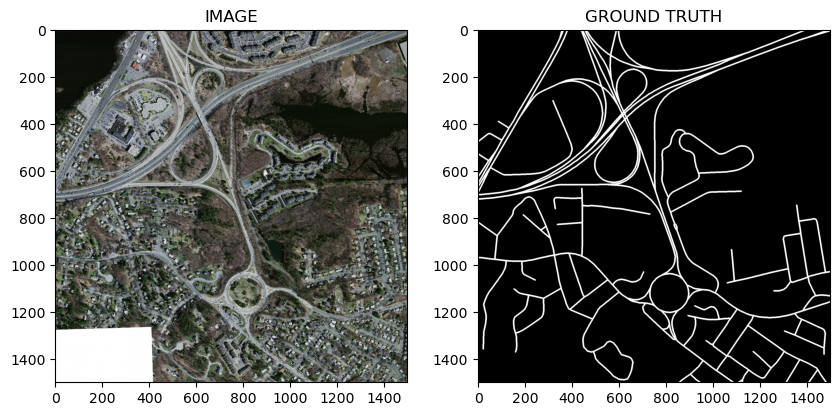

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3: Augmentation Functions

In this task, we will use a library called albumentations. Albumentation is a well know library for data augmentation it is very useful for a task like object detection, key point detection, classification and segmentation.

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),     
    ])

In segmentation, the scenario is different. When you will rotate the aerial image it's mask should also rotate. If you're going to flip the aerial image, its mask should also flip.

In [12]:
def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ])

# Task 4: Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):
    
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]

        image_path = DATA_DIR +  row.images
        mask_path = DATA_DIR + row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # (h, w, c)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w)
        mask = np.expand_dims(mask, axis = -1) #(h,w,c)
        
        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image'] # (h, w, c)
            mask = data['mask']
            
        
        image = np.transpose(image, (2, 0, 1)).astype(np.float32) # (c, h, w)
        mask = np.transpose(mask, (2, 0 ,1)).astype(np.float32) # (c, h, w)
        
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)
        
        
        return image, mask

In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


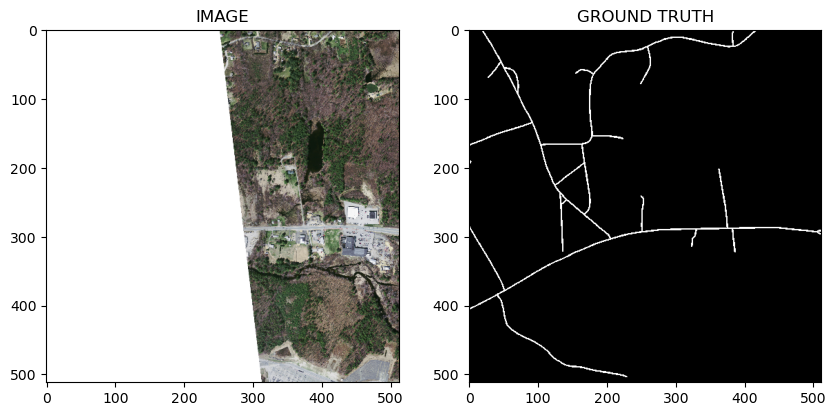

In [17]:
idx = 45

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5: Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [20]:
print("Total number of batches in trainloader: {}".format(len(trainloader)))
print("Total number of batches in validloader: {}".format(len(validloader)))

Total number of batches in trainloader: 20
Total number of batches in validloader: 5


In [21]:
for image, mask in trainloader:
    print("One batch image shape: {}".format(image.shape))
    print("One batch mask shape: {}".format(mask.shape))
    break;

One batch image shape: torch.Size([8, 3, 512, 512])
One batch mask shape: torch.Size([8, 1, 512, 512])


# Task 6: Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3, # rgb channel
        classes = 1, # binary segmentation problem
        activation = None
    )

  def forward(self, images, masks = None): 
    
    logits = self.backbone(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [24]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7: Create Train and Validation Function

In [25]:
def train_fn(data_loader, model, optimizer): 

  model.train() # Turn ON dropout, batchnorm, etc...
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [26]:
def eval_fn(data_loader, model): 

  model.eval() # Turn OFF dropout, batchnorm, etc...
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [28]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED-MODEL')
    best_loss = valid_loss

  print(f'Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}')

100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


SAVED-MODEL
Epoch : 1 Train_loss : 1.1339848190546036 Valid_loss : 1.005064272880554


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


SAVED-MODEL
Epoch : 2 Train_loss : 0.7604330867528916 Valid_loss : 0.8639902830123901


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


SAVED-MODEL
Epoch : 3 Train_loss : 0.6904821366071701 Valid_loss : 0.7210524201393127


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch : 4 Train_loss : 0.6870980769395828 Valid_loss : 0.7537719130516052


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


SAVED-MODEL
Epoch : 5 Train_loss : 0.6569091439247131 Valid_loss : 0.687052869796753


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch : 6 Train_loss : 0.6315935611724853 Valid_loss : 0.68882896900177


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch : 7 Train_loss : 0.628802964091301 Valid_loss : 0.7007180094718933


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch : 8 Train_loss : 0.6419301241636276 Valid_loss : 0.7050083994865417


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch : 9 Train_loss : 0.6195890247821808 Valid_loss : 0.70166916847229


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


SAVED-MODEL
Epoch : 10 Train_loss : 0.6181169152259827 Valid_loss : 0.6756873488426208


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


SAVED-MODEL
Epoch : 11 Train_loss : 0.6047479122877121 Valid_loss : 0.6616355061531067


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


SAVED-MODEL
Epoch : 12 Train_loss : 0.5923021912574769 Valid_loss : 0.6241770148277282


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch : 13 Train_loss : 0.604908449947834 Valid_loss : 0.6569029688835144


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch : 14 Train_loss : 0.5964003443717957 Valid_loss : 0.6474779486656189


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch : 15 Train_loss : 0.5914815053343773 Valid_loss : 0.7133094906806946


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


SAVED-MODEL
Epoch : 16 Train_loss : 0.5917319387197495 Valid_loss : 0.6185378909111023


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch : 17 Train_loss : 0.5848943188786506 Valid_loss : 0.6340744018554687


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch : 18 Train_loss : 0.5744845658540726 Valid_loss : 0.6389716744422913


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch : 19 Train_loss : 0.578250715136528 Valid_loss : 0.6556089758872986


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch : 20 Train_loss : 0.5735402122139931 Valid_loss : 0.624277400970459


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


SAVED-MODEL
Epoch : 21 Train_loss : 0.5638504505157471 Valid_loss : 0.592858898639679


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch : 22 Train_loss : 0.5638045534491539 Valid_loss : 0.6269487142562866


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch : 23 Train_loss : 0.5640778064727783 Valid_loss : 0.6322266936302186


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch : 24 Train_loss : 0.558721375465393 Valid_loss : 0.6381853818893433


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

Epoch : 25 Train_loss : 0.560052752494812 Valid_loss : 0.6126917243003845


# Task 9 : Inference

In [29]:
idx = 21 # eg

model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c,h,w) -> (1, c, h, w)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

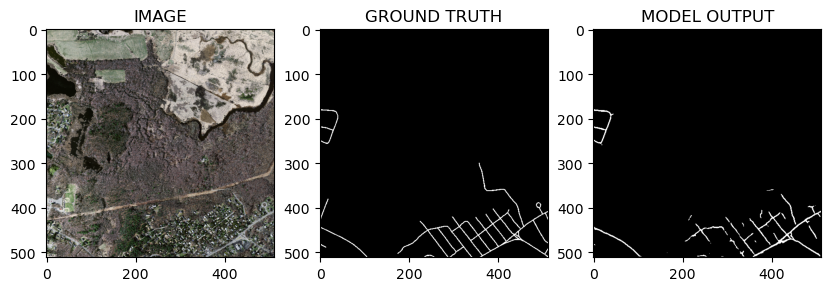

In [30]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0) )